In [1]:
# def store_memory(result, user_id):
#      history.update_one({"user_id":user_id}, {"$push":{
#           "chat_history" : {"$each":[
#                          (result["messages"][0].content),
#                          (result["messages"][-1].content)
#                             ]}}})

# def QA(question, user_id):
#      query = history.find_one({"user_id": user_id})
#      if query is None:
#           query = {
#                "user_id": user_id,
#                "chat_history": [],
#           }
#           history.insert_one(query)
     
#      chat_history = []
#      for i, msg in enumerate(query["chat_history"]):
#           chat_history.append(
#                AIMessage(msg) if i % 2 == 1 else HumanMessage(msg)
#           )

#      result = graph.invoke({
#           "messages": [
#                HumanMessage(
#                     content=question
#                )
#           ],
#           "chat_history":chat_history,
          
#      },)
#      store_memory(result, user_id)
#      return result

In [2]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose

set_verbose(True)
set_debug(False)

import functools
# for llm model
from langchain_openai import ChatOpenAI
# from langchain_community.chat_models import ChatOpenAI
from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import (
    find_place_from_text, 
    nearby_search, 
    nearby_dense_community, 
    search_population_community_household_expenditures_data,
    duckduckgo_search,
    get_tools_output
)
from agents import(
    create_agent,
    AgentState
)

## tools and LLM
# Bind the tools to the model
tools = [search_population_community_household_expenditures_data, find_place_from_text, nearby_search, nearby_dense_community, duckduckgo_search]  # Include both tools if needed

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0.0)

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        # result = AIMessage(**result.dict(), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


## Define Agents Node ------------------------------------------------------------------------
# Research agent and node
from prompt import agent_meta
agent_name = [meta['name'] for meta in agent_meta]

# TODO: move agents to agents.py 
agents={}
agent_nodes={}

for meta in agent_meta:
    name = meta['name']
    prompt = meta['prompt']
    
    agents[name] = create_agent(
            llm,
            tools,
            system_message=prompt,
        )
    
    agent_nodes[name] = functools.partial(agent_node, agent=agents[name], name=name)


## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(tools)

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "continue" in last_message.content:
        return "continue"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "%SIjfE923hf" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, node in agent_nodes.items():
    workflow.add_node(name, node)
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    router,
    {"continue": "data_collector", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "data_collector",
    router,
    {"call_tool": "call_tool", "continue": "reporter", "__end__": END}
)

workflow.add_conditional_edges(
    "reporter",
    router,
    {"continue": "data_collector", "call_tool": "call_tool", "__end__": END}
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


chat_history=[]
def submitUserMessage(user_input: str, keep_chat_history:bool=True, return_reference:bool=False, verbose=False) -> str:
    global chat_history
    chat_history.append(HumanMessage(user_input))
    
    if not keep_chat_history:
        chat_history = []
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": 20},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]["messages"][0]
    else:
        for e in events:
            # print(e)
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]['messages'][0]
    
    
    response = response.content
    response = response.replace("%SIjfE923hf", "")
    
    chat_history.append(AIMessage(response))
    chat_history = chat_history[-10:]
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

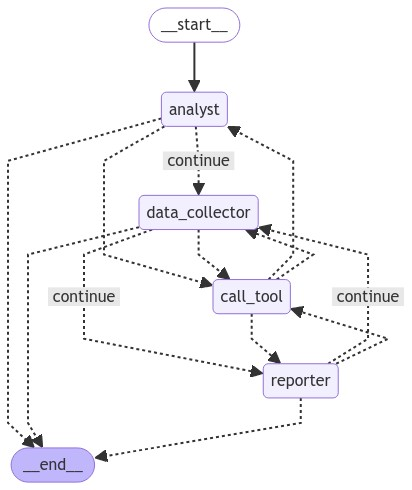

In [3]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
result = submitUserMessage("วิเคราะห์การเปิดโรงแรมแถวทองหล่อ", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_gI5r2LnhnJfKIQzpr3jF8COu)
 Call ID: call_gI5r2LnhnJfKIQzpr3jF8COu
  Args:
    location: ทองหล่อ
  search_population_community_household_expenditures_data (call_CWtsa4MiJ3aO3kbIQVKxIP0y)
 Call ID: call_CWtsa4MiJ3aO3kbIQVKxIP0y
  Args:
    query: ทองหล่อ
================================= Tool Message =================================
Name: find_place_from_text


    address: ถ. ทองหล่อ กรุงเทพมหานคร ประเทศไทย

    location_name: ถ. ทองหล่อ

    
================================== Ai Message ==================================
Name: analyst

### รายงานการวิเคราะห์การเปิดโรงแรมแถวทองหล่อ

#### 1. สรุป
- **ภาพรวมสั้น ๆ:** การเปิดโรงแรมในย่านทองหล่อมีศักยภาพสูง เนื่องจากเป็นพื้นที่ที่มีความนิยมทั้งจากคนท้องถิ่นและนักท่องเที่ยว โดยเฉพาะในกลุ่มคนที่มองหาที่พักที่มีคุณภาพและบริการที่ดี
- **ข้อสรุปความเป็นไปได้:** โครงการนี้มีความเป็นไปได้สูง เนื่องจากมีการจราจรห

In [5]:
# submitUserMessage("ราคาเหมาะสมที่ต้องขาย", keep_chat_history=True, return_reference=True, verbose=True)